In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import itertools
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from lab_4_functions import word_plotter, nmf_metrics

# Step 1 EDA 
## Training Data

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


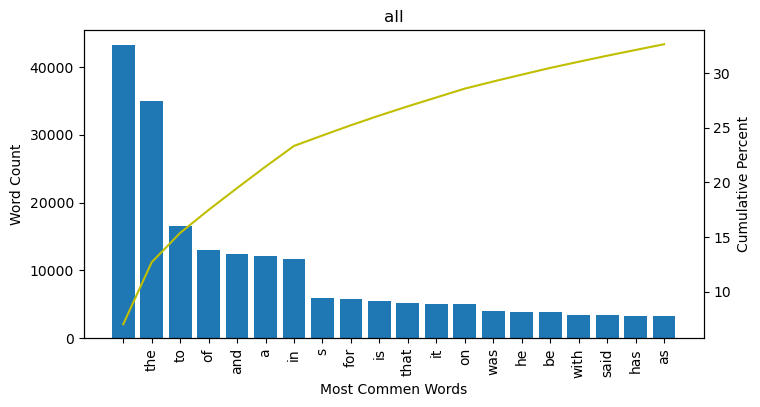

In [2]:
# First import the data and take a look at it
df_train = pd.read_csv('BBC News Train.csv')
print(df_train.head())
# I made a function to plot a cumulative histogram of the n most common words, see lab_4_functions.py for details 
word_plotter(df_train, num_words = 20)

From the above graph we can see that the most common words aren't going to provide much information for classifying the text documents. Lets try filtering out words and see if we can get a more useful data set. Sklearn has a list of English stop words that provide a good starting point. 

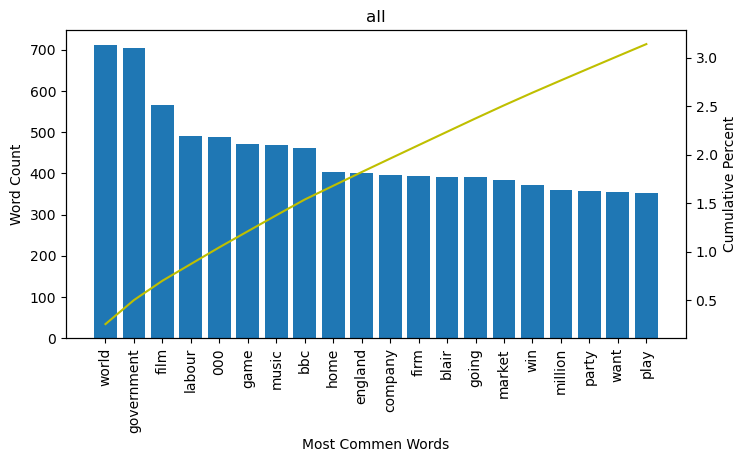

In [3]:
from sklearn.feature_extraction import text
filter_words = list(text.ENGLISH_STOP_WORDS)
# The below list was generated by repeatedly running this cell and adding words that I didn’t think 
# would be useful for classification.
train_filter_words = filter_words + ['', 's', 'said', '-', 'said.', '.', 'mr', 't', 'year','new', 'just', 'best', 'like',
                'said:', 'way', 'use', 'say', 'including', 'set', 'used', 'o', 'people', 'm', 'uk', 
                'brown', 'told', 'time', 'make', 'number', 'good', 'says', 'years', 'won']
word_plotter(df_train, num_words = 20, filter_words = train_filter_words)

As a check let's look at the top ten words for each category.

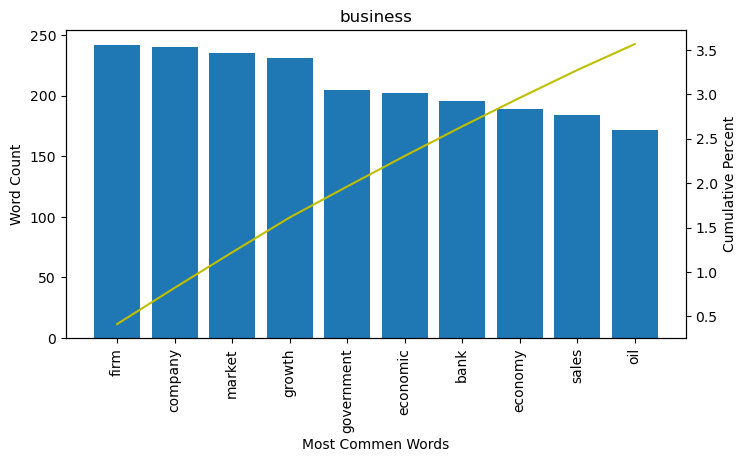

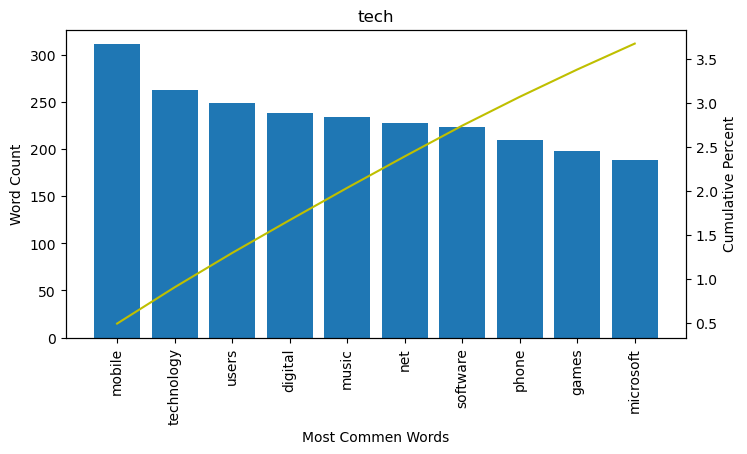

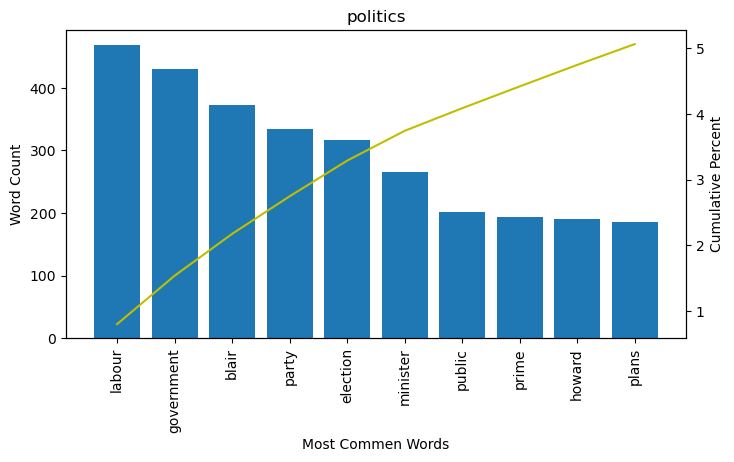

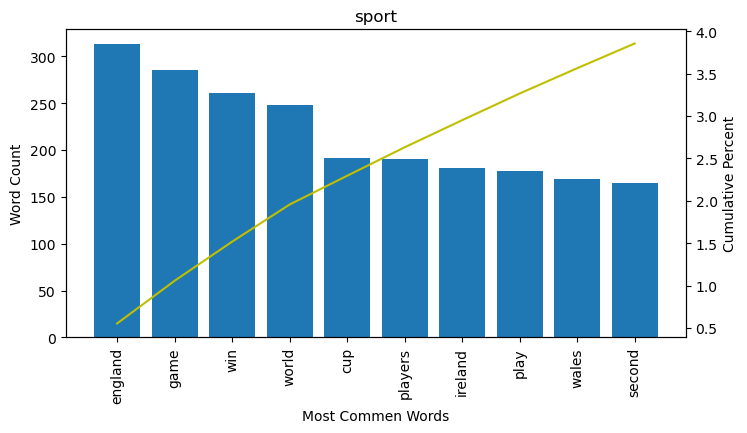

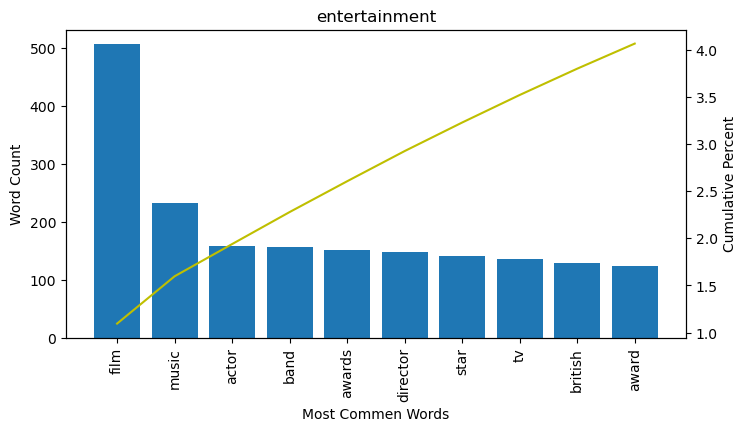

In [4]:
for cat in df_train.Category.unique():
    word_plotter(df_train, num_words = 10, filter_words = train_filter_words, cat = cat)#, show_words = True)

Based on the above graphs the top ten words for each category should be useful in classifying the documents. One thing of interest is that the top ten words for each category only make up three to four percent of the total word count. It was less than I initially expected it to be. However since the cumulative frequency of the top 20 unfiltered words was ~30 % it does make sense that the cumulative frequency of the less common topic specific words would be much lower. Indicating that I have found a good set of filter words.

## Test Data

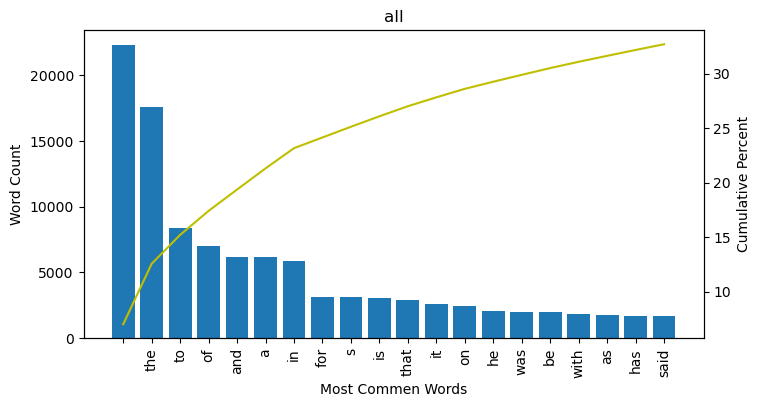

In [5]:
# Import the Test data and take a look at it
df_test = pd.read_csv('BBC News Test.csv')
df_test.head()
# Plot a cumulative histogram of the unfiltered data
word_plotter(df_test, num_words = 20)

The top 20 words for all articles are ['government', 'world', 'time', 'make', 'best', 'uk', 'music', 'labour', 'bbc', 'game', 'way', 'company', 'film', '000', 'party', 'games', 'technology', 'home', 'work', 'market']


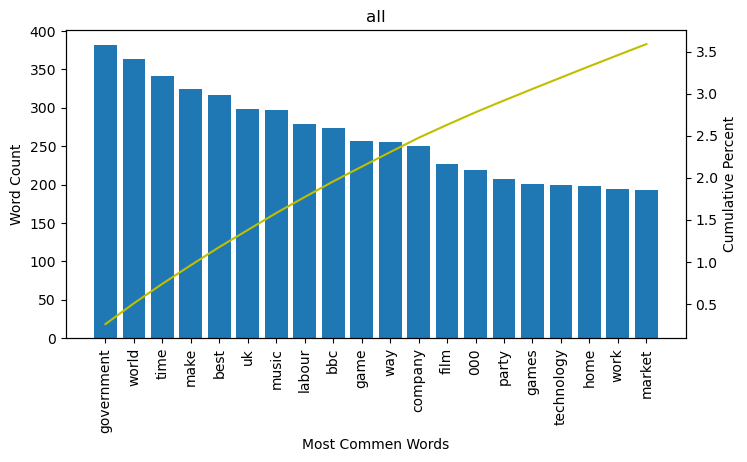

In [6]:
# make a new filter list and replot the data
test_filter_words = filter_words + ['', 's', 'said', '-', 'mr', 'people', 'new', 't', 'said.', '.', 'just', 'told', 'like', 'years', 'year',
                                   'think', 'said:', 'number', 'going', 'set', 'says', 'did', 'good']
word_plotter(df_test, num_words = 20, filter_words = test_filter_words, show_words = True)

### “When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix?" 

I am assuming since NMF is unsupervised and you don’t train an unsupervised model this is referring to the preprocessing of the data. In which case no data from the training data should be included in the preprocessing of the test data. When we vectorise the data any words present from the training dataset but not in the test dataset would complicate the model and potentially lead to poorer results. 

Keeping with the above reasoning there should be a second list of filter words for the test data. 

## TFID and Text Vectorization

Before we can run NMF we need to vectorise the data, one method to do that is TFID. TFID stands for Term Frequency Inverse Document Frequency. The idea is that common words that appear across many documents won't help in classification and are weighted less while words that appear in fewer documents are weighted more. The frequency a term is used in a single document is also considered and is weighted more heavily the more often that term appears in a document. From sklearn the equation is “tf-idf(t, d) = tf(t, d) * idf(t), and the idf is computed as idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False ), where n is the total number of documents in the document set and df(t) is the document frequency of t.” 

To do that calculation the TfidfVectorizer first has to turn the raw text data into vectors. That is done by creating a dictionary where each word is assigned a token. A matrix is then created with the rows representing documents and the columns representing tokens (or words). The matrix is then filled out with each number representing the total number of times a term appeared in a document.

I will use Sklearn's tfidf_vectorizer to preforme this process. 

In [7]:
# vectorizing the data looks like this 
tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words) # pass in the list of words so the vectorizor will exclude them
# Apply the vectorizer object to the train data and it will return a Tfidf weighted document-term matrix.
tfidf = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())

# Step 2 Building and training Models.

First let's define some utility functions that will help evaluate the models.

Some important concepts expressed in the code below are that a NMF model once run has two matrices, a weight and topic matrix. The weight matrix will have the categories or topics as columns and document ids as rows. The column with the highest score indicates which category the NMF is predicting that document will be. The weight matrix has the words that the vectorizor used as columns and the topics as rows. Determining the most used words per category can be done by finding the columns with the highest scores. 

In [9]:
def nmf_metrics(nmf, w, tfidf_vectorizer, plot=False, true_labels = None):
    """Prints out the accuracy and optionally makes a plot displaying the 
    top 10 words and categories for the nmf model results. True labels is an 
    optional list of labels that will be used as the true labels in sklearn 
    accuracy score function. The default is the labels from Kaggl’s train dataset. """

    # Convert the numerical labels to text categories and return the accuracy score.
    if true_labels is None:
        best_label, acc = label_permute_compare(df_train.Category, get_predictions(w))
    else:
        best_label, acc = label_permute_compare(true_labels, get_predictions(w))

    # Get the list of words created by the vectorizer.
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    if plot:
        # make a plot showing each catagory and its top words
        plot_top_words(nmf, tfidf_feature_names, 10, "NMF", best_label)
        
    return acc

def label_permute_compare(true_, predicted, n=5):
    """Gets the combination of labels that results in the highest accuracy. Modified from week 2."""
    perms = itertools.permutations(['business', 'tech', 'politics', 'sport', 'entertainment'])
    
    acc = 0.0
    best_order = 0
    for perm in perms:
        pred = [perm[i] for i in predicted]
        pred_acc = sum([1 for x, y, in zip(list(true_), pred) if x == y]) / len(true_)
        if pred_acc > acc:
            acc = pred_acc
            best_order = perm
            
    return best_order, acc

def plot_top_words(model, feature_names, n_top_words, title, subtitles):
    '''Takes the nmf model, a list of category names and some styling information for the graph.
    It then plots a horizontal bar chart for each category. Modified from the sklearn example here
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html'''
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        # sorts the array and graps the top n indices
        top_features_ind = topic.argsort()[-n_top_words:]
        # converts indices to words
        top_features = feature_names[top_features_ind]
        # grab the top words
        weights = topic[top_features_ind]

        # make a horizontal bar chart of top n words
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(subtitles[topic_idx], fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def get_predictions(w):
    """Get the index of the column with the highest count I.E the category and return it."""
    predictions = np.argmax(w, axis=1)
    return predictions

def show_words_for_topics(topic, words,  num_words = 10):
    '''Takes the H matrix from nmf and a matrix of the words in the text. Picks the num_words with the highest 
    score for each category and returns them'''
    return np.apply_along_axis(lambda x: words[(np.argsort(-x))[:num_words]], 1, topic)


## Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.

Let's run a NMF model. I’ll define one more function below to run the model and return the accuracy, as well as a plot of the predicted top words per category. To start with I’ll use my list of train filter words for the vectorizor, five components for the NMF n_componets factor and leave all other options as default.

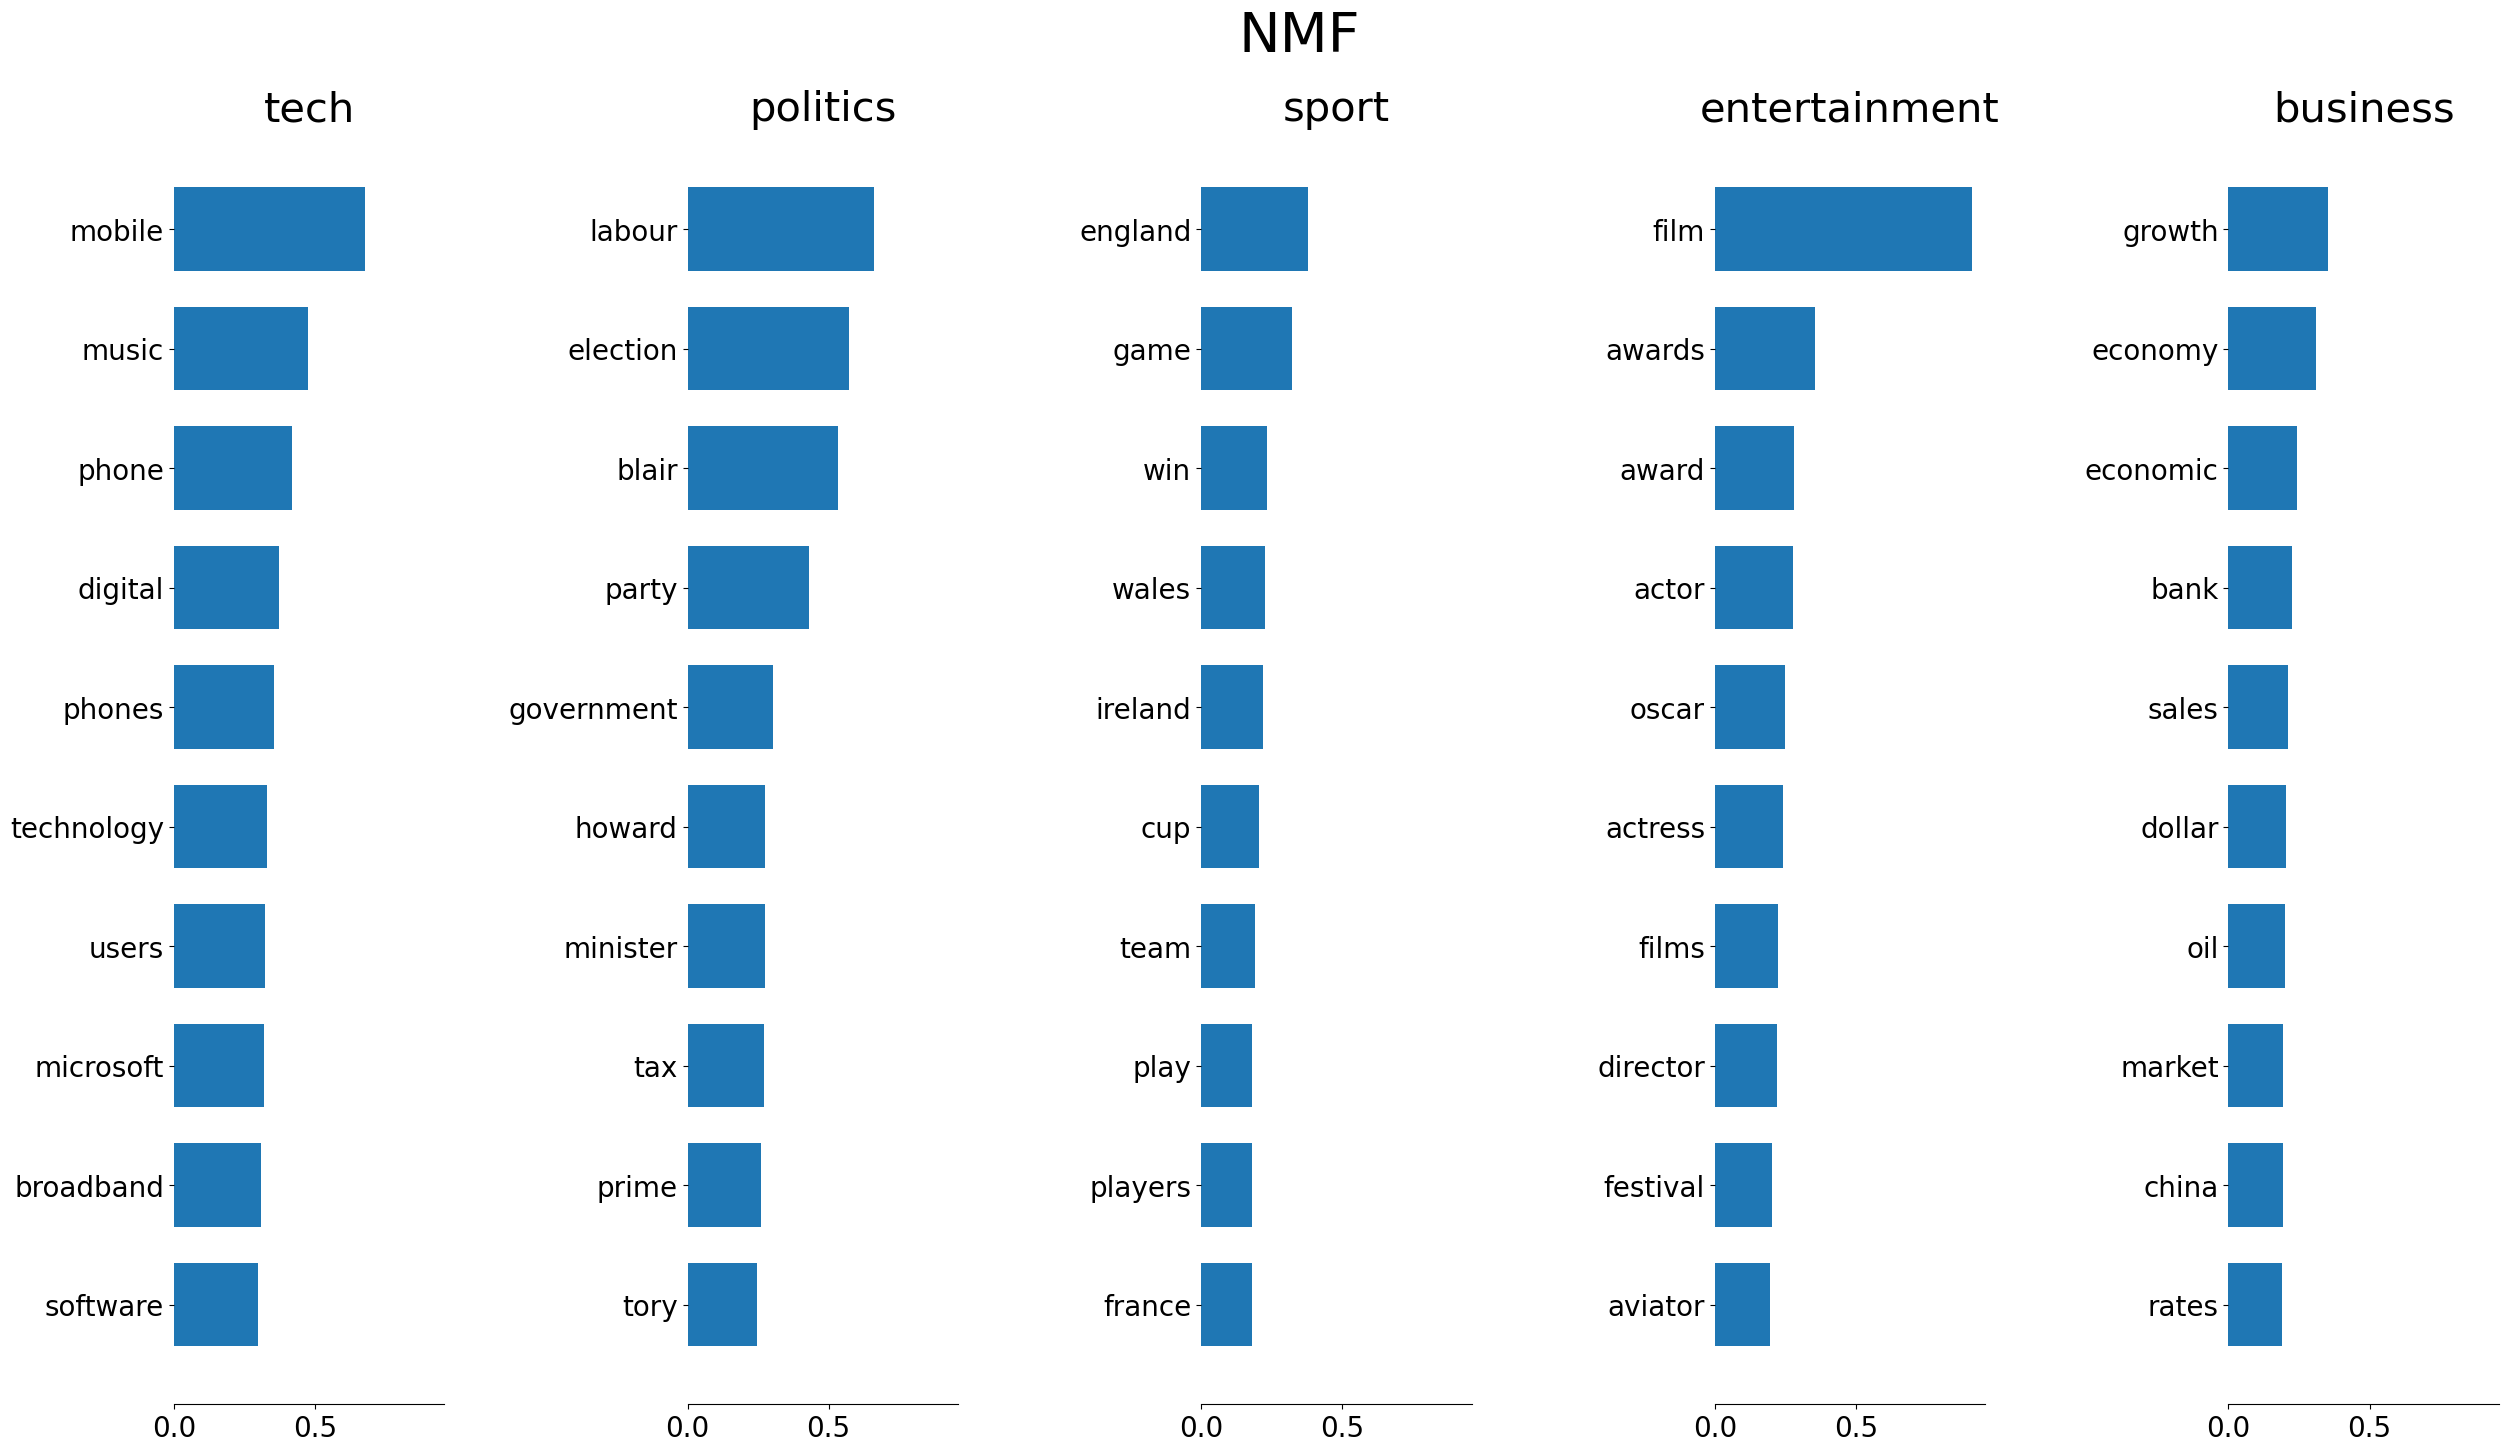

the model accuracy was : 0.9080536912751678


In [10]:
def run_nmf_train(min_df = 0, max_df = 1, plot = False, use_df = False):
    """Since I will be performing this multiple times I wrote a function that vectorises the data
    and optionally a plot can be printed showing the resulting top words per category as predicted 
    by the NMF model, and the df_min and df_max variables can be passed to the vectorizor rather 
    than the list of stop words."""
    
    # Use either the list of filter words or the frequency a term appears across all document to filter words.
    if use_df == True:
        tfidf_vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    else:
        tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words)

    # Apply the vectorizer object to the train data
    tfidf = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())
    
    # make the nmf modle and set n_componets = to 5 because we have 5 catogries.
    nmf = NMF(n_components = 5, random_state = 0)
    
    # run the model
    w = nmf.fit_transform(tfidf)

    # Get accuracy and maybe plot the top words.
    acc = nmf_metrics(nmf, w, tfidf_vectorizer, plot=plot)
    return acc
acc = run_nmf_train(plot=True)
print('the model accuracy was : %s' % acc)

## Measure the performances on train dataset
Out of the gate the NMF returns 90% accuracy on the training data. Lets try optimizing some hyperparameters and see if that improves.

## Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs

 Creating the list of filter words was time consuming and manual. I am interested to see if the TfidfVectorizer’s max and min df parameters can produce a better or a comparable result. The max and min df parameters refer to the frequency a word appears across all documents and excludes that word if it is outside those bounds. For example if the max_df is .5 and the word “fish” is found in 51% of the documents then “fish” will not be included in the Tfid matrix. 

/Users/benkupernk/opt/anaconda3/envs/pycharm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/benkupernk/opt/anaconda3/envs/pycharm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


The best model has an accuracy of 0.9456375838926174 with a max frequency of 0.1 and a minimum frequency of 0.01.


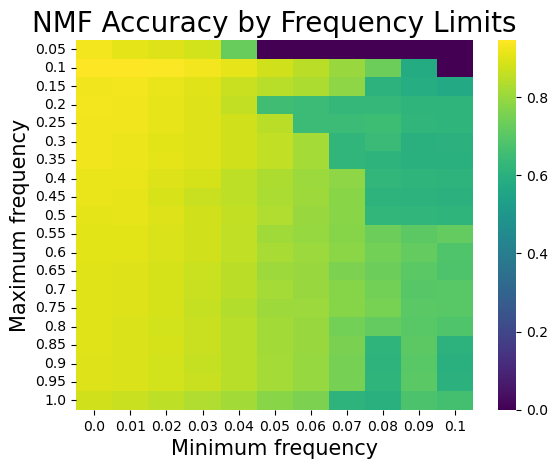

In [12]:
# make a list of min and max frequencies to be considered
max_df_list = list(range(100,0, -5))
max_df_list =[.01* val for val in max_df_list]

min_df_list = list(range(0,11, 1))
min_df_list =[.01* val for val in min_df_list]

# store the values
acc_dict = {}
# test nmf modles with diffrent allowed frequencies.
for max_df in max_df_list:
    for min_df in min_df_list:
        if max_df > min_df:
            acc = run_nmf_train(max_df = max_df, min_df = min_df, use_df = True)
            acc_dict[(max_df, min_df)] = acc

# plot the results in a heat map.
ser = pd.Series(list(acc_dict.values()),
                  index=pd.MultiIndex.from_tuples(acc_dict.keys()))
df_acc_results = ser.unstack().fillna(0)
df_acc_results.index = [round(idx, 2) for idx in df_acc_results.index]
ax = sns.heatmap(df_acc_results, cmap = 'viridis') 

plt.title('NMF Accuracy by Frequency Limits', fontsize = 20)
plt.xlabel('Minimum frequency', fontsize = 15)
plt.ylabel('Maximum frequency', fontsize = 15)
print('The best model has an accuracy of %s with a max frequency of %s and a minimum frequency of %s.' % 
     (max(acc_dict.values()), max(acc_dict, key=acc_dict.get)[0], max(acc_dict, key=acc_dict.get)[1]))  

This optimal frequency range was lower than I expected but it is consistent with the 3% to 4% frequency we saw when looking at the top ten words in each category during the EDA, indicating that the topic words will have a low total frequency count when considered against all the documents.

Now lets run NMF on the Test data.

## Measure the performances on test dataset

In [39]:
# vectorize the text using the tfidf method
tfidf_vectorizer = TfidfVectorizer(stop_words=test_filter_words)
tfidf = tfidf_vectorizer.fit_transform(df_test.Text.to_numpy())

# make the nmf modle and set n_componets = to 5 because we have 5 catogries.
nmf = NMF(n_components = 5, random_state = 0)
# run the modle
w = nmf.fit_transform(tfidf)

# get predicted catagories
predictions = get_predictions(w)
# see the top ten words for each catagory
vocab = tfidf_vectorizer.get_feature_names_out()
print(show_words_for_topics(nmf.components_, tfidf_vectorizer.get_feature_names_out()))
print(df_train.Category.unique())

[['music' 'mobile' 'technology' 'digital' 'users' 'broadband' 'games'
  'apple' 'phone' 'computer']
 ['labour' 'election' 'blair' 'brown' 'party' 'howard' 'chancellor'
  'government' 'tax' 'tory']
 ['economy' 'growth' 'bank' 'prices' 'oil' 'economic' 'yukos' 'sales'
  'china' '2004']
 ['england' 'game' 'rugby' 'wales' 'win' 'match' 'play' 'players'
  'ireland' 'team']
 ['film' 'best' 'award' 'awards' 'festival' 'prize' 'oscar' 'films' 'won'
  'aviator']]
['business' 'tech' 'politics' 'sport' 'entertainment']


Since we don’t have any labeled data, text categories have to be assigned to labeled data manually. Fortunately it looks like the model worked well and there is a clear trend for each row in the weight matrix.

In [40]:
# assign each catogory to its numeric label
cat_dict = {0:'tech', 1:'politics', 2:'business', 3:'sport', 4:'entertainment'}
df_test['Category'] = [cat_dict[val] for val in predictions]
df_test
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('test_predictions.csv', index = False)

Kaggle gave me a score of 94.6%. Not too bad. Lets try with the max and min df.

## Improve the model performance if you can

In [34]:
tfidf_vectorizer = TfidfVectorizer(max_df = .1, min_df = .01)
tfidf = tfidf_vectorizer.fit_transform(df_test.Text.to_numpy())

# make the nmf modle and set n_componets = to 5 because we have 5 catogries.
nmf = NMF(n_components = 5, random_state = 0)
# run the modle
w = nmf.fit_transform(tfidf)

# get my predicted catagories
predictions = get_predictions(w)
# see the top ten words for each catagory
vocab = tfidf_vectorizer.get_feature_names_out()
print(show_words_for_topics(nmf.components_, tfidf_vectorizer.get_feature_names_out()))
print(df_train.Category.unique())

[['blair' 'brown' 'howard' 'chancellor' 'prime' 'tory' 'tax' 'tories'
  'budget' 'tony']
 ['club' 'wales' 'injury' 'rugby' 'ireland' 'cup' 'coach' 'squad'
  'season' 'victory']
 ['mobile' 'digital' 'phone' 'computer' 'video' 'software' 'broadband'
  'apple' '3g' 'data']
 ['bank' 'oil' 'prices' 'yukos' 'china' 'shares' 'stock' 'rate'
  'deutsche' 'rose']
 ['award' 'awards' 'festival' 'prize' 'album' 'oscar' 'band' 'actress'
  'films' 'comedy']]
['business' 'tech' 'politics' 'sport' 'entertainment']


In [35]:
# assign each catogory to its numeric label
cat_dict = {0:'tech', 1:'politics', 2:'sport', 3:'business', 4:'entertainment'}
df_test['Category'] = [cat_dict[val] for val in predictions]
df_test
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('test_predictions_no_filter.csv', index = False)

Submitting the new file to Kaggle gives me a score of 92.6. A little worse than my list of filter words. This is likely due to the fact that the min and max df frequencies are optimized for the train words not the test words, whereas the test_filter words are optimized for the test data. This indicates that when it is not possible or convenient to run a hyperparameter optimization script it is worth the effort of manually creating a word filter list.

# Step 3 Compare with supervised learning

Now let's try a supervised learning approach. I'm going to use Multinomial Naive Bayes. This method works by assuming that the data distribution approximates a gaussian distribution. Since each category has a distinct set of words that seems like a successful approach. Also it works well with high dimension data.

I am also going to compare it to KNN which I expect to perform poorly due to the high dimensionality and SVC, which I expect will be computationally efficient but I don’t know how well it will perform.

In [17]:
# a list to hole all the model accuracy results
big_old_list_of_stuff = []

tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words, max_df =.25, min_df = 0.05)
tdif_x = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())

# lets see how each model performs based on how much data it is allowed to train on
train_percent_list = list(range(1, 10, 1))
train_percent_list = [round(val * .1,1) for val in train_percent_list]
for j in train_percent_list:

    # split the traning data
    X_train, X_test, y_train, y_test = train_test_split(tdif_x, df_train.Category, test_size=j, random_state=0)

    # make the models
    model1 = MultinomialNB()
    model2 = KNeighborsClassifier(n_neighbors=3)
    model3 = SVC()
    model4 = NMF(n_components = 5, random_state = 0)

    # train them
    model1.fit(X_train, y_train) 
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)

    # run them
    y_pred1 = model1.predict(X_train)
    y_pred2 = model2.predict(X_train)
    y_pred3 = model3.predict(X_train)
    w = model4.fit_transform(X_train)
    
    # get teh accuracy
    acc1_t = accuracy_score(y_train, y_pred1)
    acc2_t = accuracy_score(y_train, y_pred2)
    acc3_t = accuracy_score(y_train, y_pred3)
    acc4_t = nmf_metrics(model4, w, tfidf_vectorizer, plot=False, true_labels = y_train)

    # now test them aganst the validation data
    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    y_pred3 = model3.predict(X_test)
    w = model4.fit_transform(X_test)
    
    acc1_v = accuracy_score(y_test, y_pred1)
    acc2_v = accuracy_score(y_test, y_pred2)
    acc3_v = accuracy_score(y_test, y_pred3)
    acc4_v = nmf_metrics(model4, w, tfidf_vectorizer, plot=False, true_labels = y_test)
    
    # store all the values
    big_old_list_of_stuff.append([acc1_t, acc2_t, acc3_t, acc4_t,  acc1_v, acc2_v , acc3_v, acc4_v])

# make the list a data fram
big_old_df = pd.DataFrame(data = big_old_list_of_stuff, columns = ['MNB_train', 'KNN_train', 'SVC_train', 'NMF_train',
                                                                   'MNB_test', 'KNN_test', 'SVC_test', 'NMF_test'])
big_old_df 

,MNB_train,KNN_train,SVC_train,NMF_train,MNB_test,KNN_test,SVC_test,NMF_test
0,0.962714,0.948546,1.000000,0.848620,0.946309,0.912752,0.946309,0.838926
1,0.963926,0.939597,0.999161,0.852349,0.946309,0.922819,0.963087,0.845638
2,0.964525,0.939597,0.999041,0.860978,0.955257,0.910515,0.959732,0.841163
3,0.968680,0.938479,0.998881,0.857942,0.941275,0.889262,0.951342,0.835570
4,0.967785,0.944966,0.998658,0.857718,0.938255,0.871141,0.944966,0.852349
5,0.964765,0.932886,0.998322,0.837248,0.936242,0.878076,0.944072,0.863535
6,0.968680,0.923937,1.000000,0.823266,0.935762,0.873442,0.935762,0.862895
7,0.973154,0.922819,1.000000,0.721477,0.932047,0.865772,0.926174,0.861577
8,0.966443,0.926174,1.000000,0.865772,0.888889,0.840418,0.867263,0.857569


The max accuracy for MNB on the train data was 0.9731543624161074
The max accuracy for MNB on the test data was 0.9552572706935123


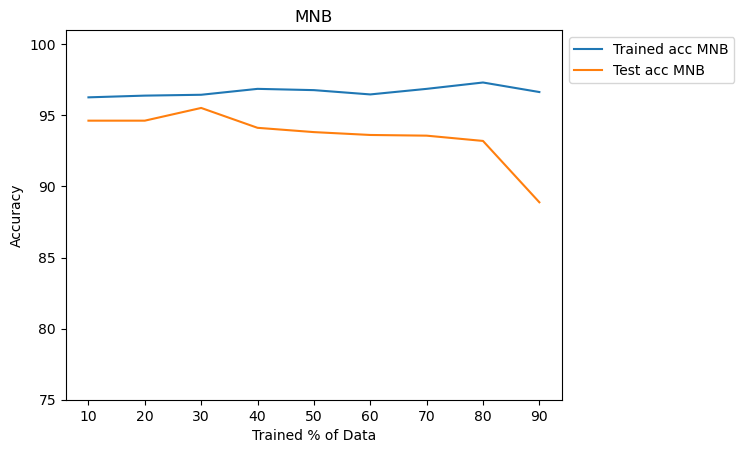

The max accuracy for KNN on the train data was 0.9485458612975392
The max accuracy for KNN on the test data was 0.9228187919463087


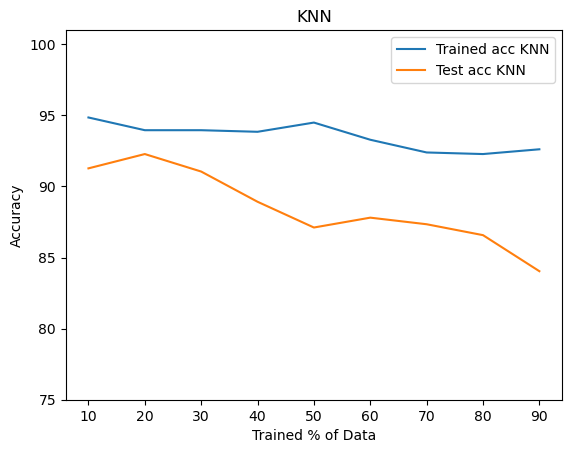

The max accuracy for SVC on the train data was 1.0
The max accuracy for SVC on the test data was 0.9630872483221476


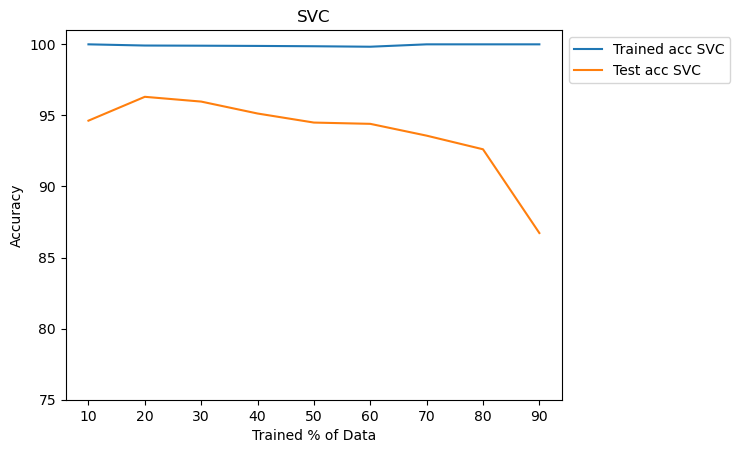

The max accuracy for NMF on the train data was 0.8657718120805369
The max accuracy for NMF on the test data was 0.8635346756152126


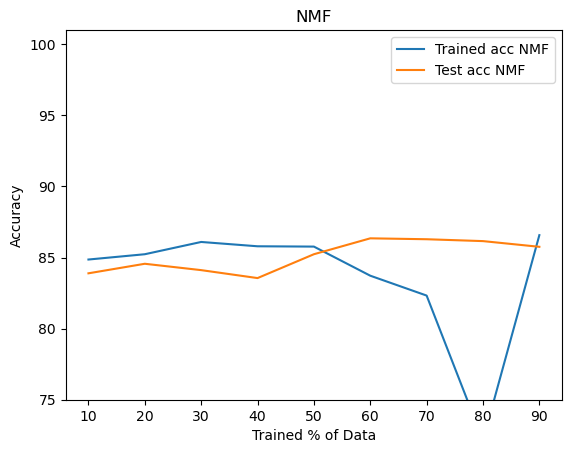

In [21]:
def model_plotter(df, model_type):
    for col in df.columns:
        if model_type in col:
            if 'train' in col:
                train_col = col
            elif 'test' in col:
                test_col = col
            else:
                print('Something bad happened and I need an adult.')
    print('The max accuracy for %s on the train data was %s' % (model_type, df[train_col].max()))
    print('The max accuracy for %s on the test data was %s' % (model_type, df[test_col].max()))
    plt.plot(list(range(10, 100, 10)), df[train_col]*100, label = 'Trained acc %s' % model_type)
    plt.plot(list(range(10, 100, 10)), df[test_col]*100, label = 'Test acc %s' % model_type)
    plt.xlabel("Trained % of Data")
    plt.ylabel("Accuracy")
    plt.ylim(75, 101)
    plt.title(model_type)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show() 
# plot everthng up 
model_plotter(big_old_df, 'MNB')
model_plotter(big_old_df, 'KNN')
model_plotter(big_old_df, 'SVC')
model_plotter(big_old_df, 'NMF')

## Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

Based on the above graph SVC is the most accurate model and the most computationally efficient since it only needs to train on 20% of the data to achieve results better than the NMF method. It also outperforms the MNB method and not surprisingly the KNN method which does not perform well in high dimensionality. As the training data nears 90% there is a consistent drop in test accuracy in each model (with the exception of NMF) indicating overfitting.

Lets try out the SVC with the test data from Kaggle

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features = 100, stop_words=train_filter_words, max_df =.25, min_df = 0.05)

# now vectorize the test and train data
X_train_tfidf= tfidf_vectorizer.fit_transform(df_train.Text)
X_test_tfidf = tfidf_vectorizer.transform(df_test.Text)

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df_train.Category, test_size=.5, random_state=0)

# train the model
model = SVC()
model.fit(X_train, y_train)

# get the predictions for the test data
y_pred = model.predict(X_test_tfidf)

# and lets put it back into a df so we can submit it to Kaggle
df_test['Category'] = y_pred
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('svc_test_predictions.csv', index = False)

Submitting the results with a train size of 20% results in a score of 89.1%. So a little under the accuracy of the NMF method but not bad. Modifying the training percentage to 10%, 30%, and 50% resulted in a score of 89.1%, 88.8% and  87.7% respectively. Supporting that the optimal training size is in the 20% range.

# References

https://medium.com/elucidate-ai/supervised-text-classification-a-beginners-guide-2439d01c14b2

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

https://spotintelligence.com/2023/09/08/non-negative-matrix-factorization/#Challenges_and_Limitations_of_NMF

https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

https://en.wikipedia.org/wiki/Non-negative_matrix_factorization